In [2]:
import sys
from IPython.utils import io # I made a change - Is this visible in Github?

In [ ]:
# if 'google.colab' in sys.modules:

#   with io.capture_output() as captured:
#      ! pip install pyhgf watermark

In [3]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.utils import beliefs_propagation

plt.rcParams["figure.constrained_layout.use"] = True

In [19]:
# Disable JIT compilation globally
jax.config.update("jax_disable_jit", False) # True - If I want the compiler disabled.

NameError: name 'jax' is not defined

In [4]:
timeserie = load_data("continuous")

two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

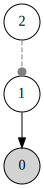

In [5]:
two_levels_continuous_hgf.plot_network()

In [6]:
max_latent_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=0)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=1)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=2)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=2)
)

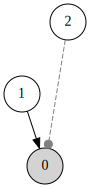

In [7]:
max_latent_hgf.plot_network()

In [8]:
# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeserie)

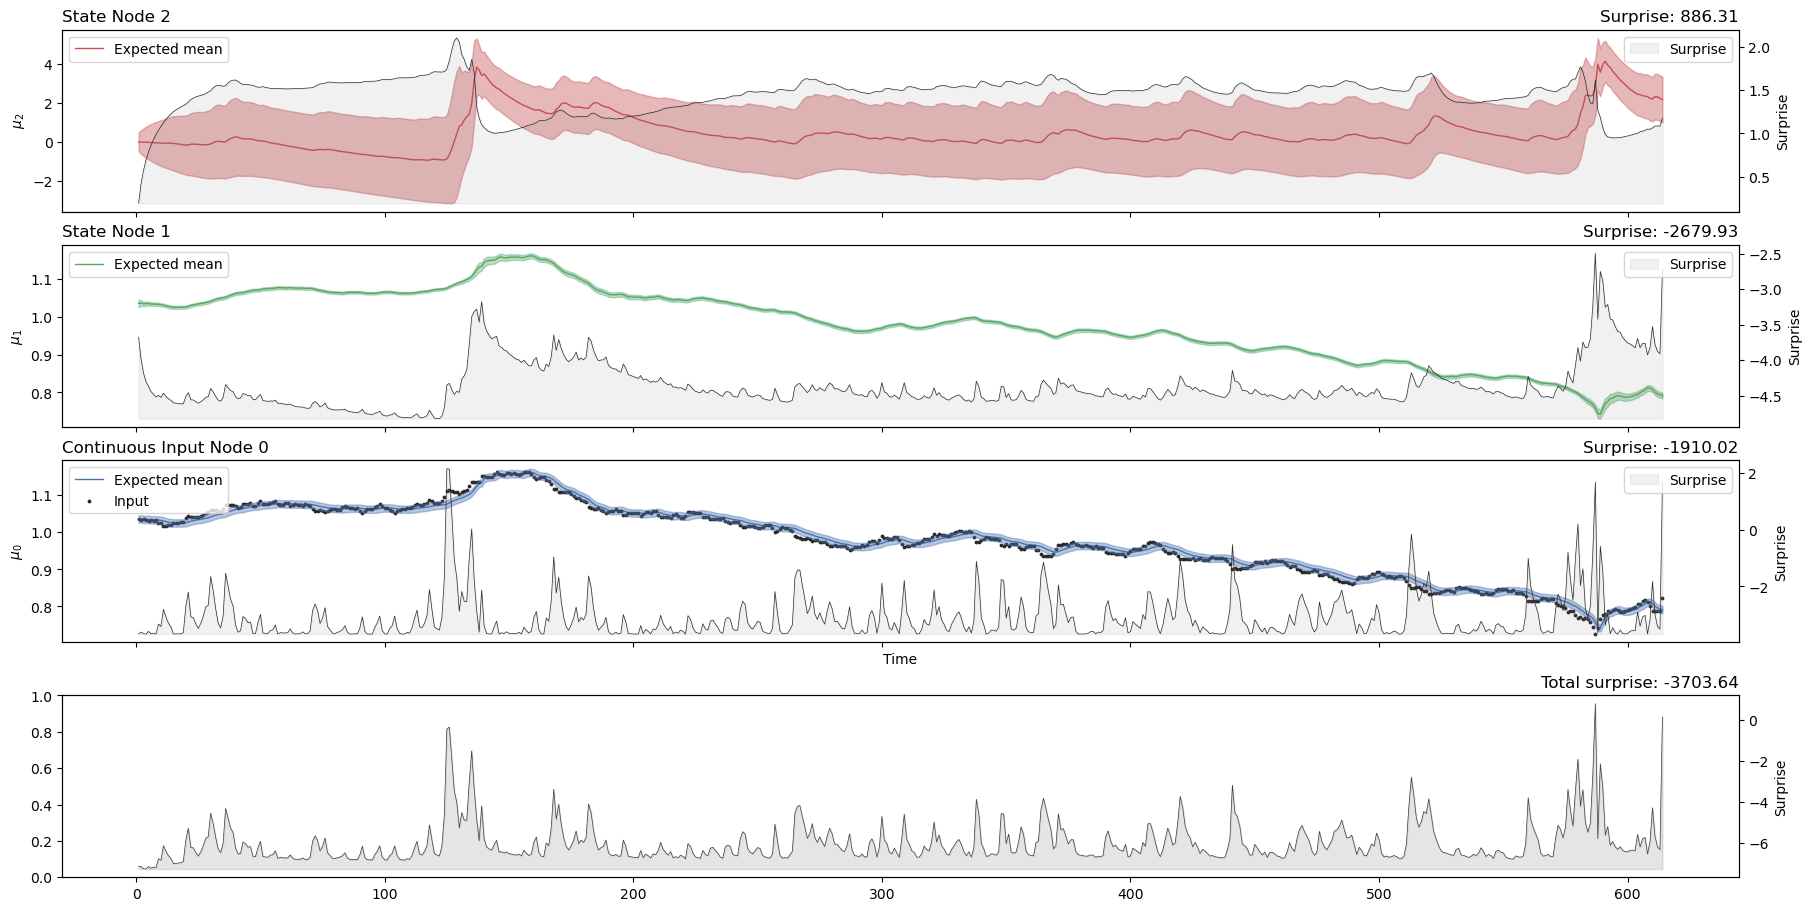

In [ ]:
two_levels_continuous_hgf.plot_trajectories(show_total_surprise=True);

In [10]:
# ensure that the results are valid
df = two_levels_continuous_hgf.to_pandas()
assert jnp.isclose(df.x_0_surprise.sum(), -1910.0183)
assert jnp.isclose(df.x_1_surprise.sum(), -2679.9297)
assert jnp.isclose(df.x_2_surprise.sum(), 886.30963)

In [11]:
# Provide new observations
max_latent_hgf = max_latent_hgf.input_data(input_data=timeserie)

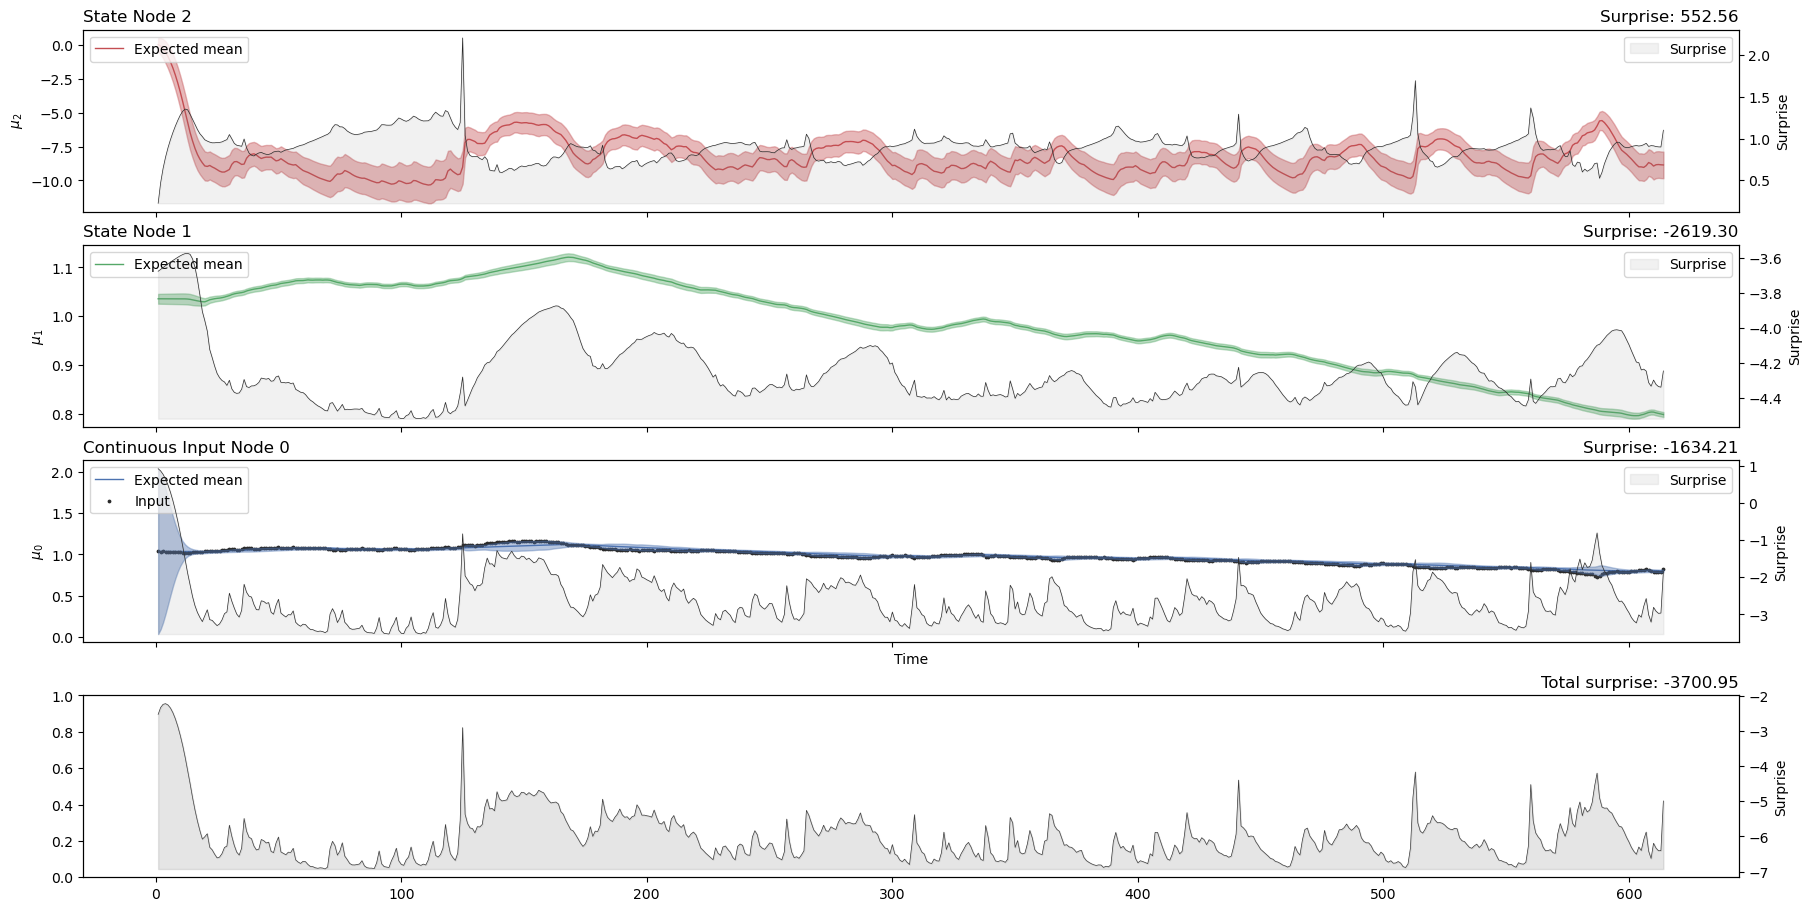

In [12]:
max_latent_hgf.plot_trajectories(show_total_surprise=True);

In [13]:
max_latent_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=0)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=1)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    # .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=2)
    # .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=2)
).create_belief_propagation_fn()

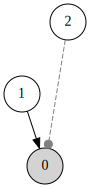

In [14]:
max_latent_hgf.plot_network()

In [28]:
attributes, edges, update_sequence = (
    max_latent_hgf.get_network()
)

print(attributes)

{-1: {'time_step': 0.0}, 0: {'mean': 0.0, 'expected_mean': 0.0, 'precision': 10000.0, 'expected_precision': 1.0, 'volatility_coupling_children': None, 'volatility_coupling_parents': (1.0,), 'value_coupling_children': None, 'value_coupling_parents': (1.0,), 'tonic_volatility': 0.0, 'tonic_drift': 0.0, 'autoconnection_strength': 0.0, 'observed': 1, 'temp': {'effective_precision': 0.0, 'value_prediction_error': 0.0, 'volatility_prediction_error': 0.0}}, 1: {'mean': 1.0357, 'expected_mean': 0.0, 'precision': 10000.0, 'expected_precision': 1.0, 'volatility_coupling_children': None, 'volatility_coupling_parents': None, 'value_coupling_children': (1.0,), 'value_coupling_parents': None, 'tonic_volatility': -13.0, 'tonic_drift': 0.0, 'autoconnection_strength': 1.0, 'observed': 1, 'temp': {'effective_precision': 0.0, 'value_prediction_error': 0.0, 'volatility_prediction_error': 0.0}}, 2: {'mean': 0.0, 'expected_mean': 0.0, 'precision': 10.0, 'expected_precision': 1.0, 'volatility_coupling_childr

In [16]:
input_data = timeserie.astype(float).T
responses = []  # 1: arm A - 0: arm B

# for each observation
for i in range(input_data.shape[0]):

    # the observation mask - default to 1
    observed = np.ones(4)

    # the time elapsed between two trials - defaults to 1
    time_steps = np.ones(1)

    # the expectations about the outcomes
    w_a = attributes[0]["expected_mean"]
    l_a = attributes[1]["expected_mean"]
    w_b = attributes[2]["expected_mean"]
    l_b = attributes[3]["expected_mean"]

    # the decision function
    p_a = np.exp(beta * (w_a - l_a)) / (
        np.exp(beta * (w_a - l_a)) + np.exp(beta * (w_b - l_b))
    )

    # sample a decision using the probability
    response = np.random.binomial(p=p_a, n=1)
    responses.append(response)

    # hide the observations that were not selected
    if response:
        observed[2:] = 0
    else:
        observed[:2] = 0

    # interleave observations and masks
    data = tuple(np.column_stack((input_data[i], np.ones(input_data[i].shape, dtype=int))).ravel())

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*data, 1.0),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=two_armed_bandit_missing_inputs_hgf.input_idxs
    )
responses = jnp.asarray(responses)  # vector of responses

KeyError: 3

In [ ]:
        # Latent Update function

def Latent_update(
        network: Network,
        attributes: Dict,
        edges: Edges,
        index: int
        ):

        attributes, edges = (
                Network.get_network()
        )

        #add node to attributes

        #Add coupling: Attempted use of "add_edges" function
        attributes, edges = add_edges(attributes, edges, 'value', new_node_idx, index)

        # ??? Create new network entirely? or alter existing network and return previous network altered
        return network


IndentationError: expected an indented block after function definition on line 5 (1391147169.py, line 8)